# Amazon Fine Food Review Analysis using Naive Bayes

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import seaborn as sn
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation

/Users/geet/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('final.sqlite') 

In [6]:
data = pd.read_sql_query("""SELECT * FROM Reviews""", con)
labels_count = sorted_data['Score'].value_counts()
# labels = sorted_data['Score']
print(labels_count)

positive    307061
negative     57110
Name: Score, dtype: int64


In [7]:
# TIme based sorting
sorted_data=data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
labels = sorted_data['Score']
print(labels.shape)
print(sorted_data.shape)

(364171,)
(364171, 12)


In [9]:
sorted_data.head()         # Time is in ascending order which means the dataset is of Time Based slicing.

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


# Bag of words

In [10]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(sorted_data['Text'].values)

In [11]:
final_counts.shape

(364171, 115281)

In [12]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_counts, labels, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

In [13]:
myList = list(range(1,11))

In [14]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score


cv_scores = []
for alpha in myList:
    nb = BernoulliNB(alpha=alpha)
    scores = cross_val_score(nb, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
print(cv_scores)

[0.870401240165665, 0.86257799114351741, 0.85612776333428608, 0.85092722046153424, 0.84757600040665493, 0.84511021791253393, 0.84389975462607869, 0.84307035454324863, 0.84259401305590453, 0.84236424551602695]


In [15]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_aplha = myList[MSE.index(min(MSE))]
print('\nThe optimal number of alpha is %d.' % optimal_aplha)


The optimal number of alpha is 1.


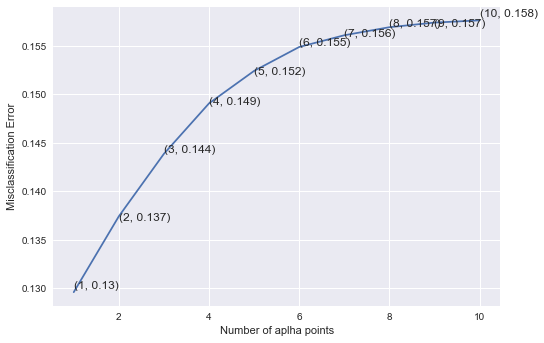

the misclassification error for each alpha is :  [ 0.13   0.137  0.144  0.149  0.152  0.155  0.156  0.157  0.157  0.158]


In [21]:
# plot misclassification error vs alpha 
plt.plot(myList, MSE)

for xy in zip(myList, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of aplha points')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha is : ", np.round(MSE,3))

In [16]:
# instantiate learning model k = optimal_k
NB_optimal = BernoulliNB(alpha=optimal_aplha)

# fitting the model
NB_optimal.fit(X_tr, y_tr)

# predict the response
pred = NB_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the NB classifier for k = %d is %f%%' % (optimal_aplha, acc))


The accuracy of the NB classifier for k = 1 is 87.029070%


In [17]:
neg_class_prob_sorted = NB_optimal.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = NB_optimal.feature_log_prob_[1, :].argsort()
print(neg_class_prob_sorted)
print(pos_class_prob_sorted)
print('top negative words \n',np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print('top positive words \n',np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

[ 57640  69382  69380 ..., 104542   8302 103373]
[ 57640  58779  58781 ..., 104542   8302 103373]
top negative words 
 ['inexpedience' 'minicroutons' 'minicongos' 'minicomgo' 'minichures'
 'minichunks' 'minichips' 'minibar' 'miniaturized' 'minicup']
top positive words 
 ['inexpedience' 'intruding' 'intruiged' 'intrying' 'intsant' 'intside'
 'intstant' 'intterested' 'intu' 'intuit']


In [18]:
print(y_test.value_counts())
import collections
print(collections.Counter(pred))
print(y_test.size)

positive    92039
negative    17213
Name: Score, dtype: int64
Counter({'positive': 94166, 'negative': 15086})
109252


In [19]:
from sklearn.metrics import confusion_matrix
labels_conf = ['negative', 'positive']
conf_mat = confusion_matrix(y_test, pred,labels = labels_conf)
print(conf_mat)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print('tn - True Negavite Rate',tn)
print('fp - False Positive Rate',fp)
print('fn - False Negative Rate',fn)
print('tp - True Positive Rate',tp)

[[ 9064  8149]
 [ 6022 86017]]
tn - True Negavite Rate 9064
fp - False Positive Rate 8149
fn - False Negative Rate 6022
tp - True Positive Rate 86017


In [20]:
TPR = tp/(tp+fn)
print('True Positive Rate',TPR)
TNR = tn/(tn+fp)
print('True Negative Rate',TNR)
FPR = fp/(tn+fp)
print('False Positive Rate',FPR)
FNR = fn/(tp+fn)
print('False Negative Rate',FNR)

True Positive Rate 0.934571214377
True Negative Rate 0.52657874862
False Positive Rate 0.47342125138
False Negative Rate 0.0654287856235


In [22]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print('precision_score',precision_score(y_test, pred,pos_label='positive'))
print('recall_score',recall_score(y_test, pred,pos_label='positive'))

precision_score 0.91346133424
recall_score 0.934571214377


In [23]:
f1 = f1_score(y_test, pred,pos_label='positive')
print(f1)

0.923895706345


# TF-IDF

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(sorted_data['Text'].values)
print(final_tf_idf.shape)

(364171, 2910192)


In [25]:
# split the data set into train and test
X_1_tf, X_test_tf, y_1_tf, y_test_tf = cross_validation.train_test_split(final_tf_idf, labels, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_tr_tf, X_cv_tf, y_tr_tf, y_cv_tf = cross_validation.train_test_split(X_1_tf, y_1_tf, test_size=0.3)

In [26]:
myList_tf = list(range(1,11))
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score


cv_scores_tf_idf = []
for alpha_tf in myList_tf:
    nb_tf = MultinomialNB(alpha=alpha_tf)
    scores_tf = cross_val_score(nb_tf, X_tr_tf, y_tr_tf, cv=10, scoring='accuracy')
    cv_scores_tf_idf.append(scores_tf.mean())
print(cv_scores_tf_idf)

[0.84355228362865164, 0.84355228362865164, 0.84355228362865164, 0.84355228362865164, 0.84355228362865164, 0.84355228362865164, 0.84355228362865164, 0.84355228362865164, 0.84355228362865164, 0.84355228362865164]


In [29]:
# changing to misclassification error
MSE_tf = [1 - x for x in cv_scores_tf_idf]

# determining best k
optimal_aplha_tf = myList_tf[MSE_tf.index(min(MSE_tf))]
print('\nThe optimal number of alpha is %d.' % optimal_aplha_tf)


The optimal number of alpha is 1.


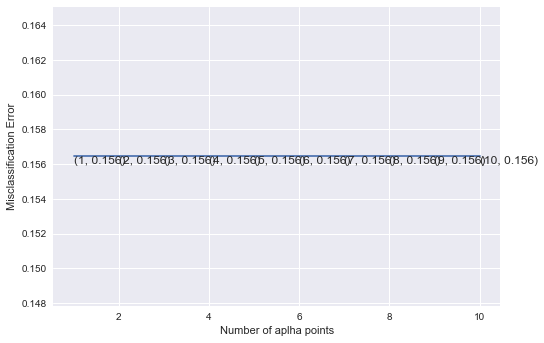

the misclassification error for each alpha is :  [ 0.156  0.156  0.156  0.156  0.156  0.156  0.156  0.156  0.156  0.156]


In [30]:
# plot misclassification error vs alpha 
plt.plot(myList_tf, MSE_tf)

for xy in zip(myList_tf, np.round(MSE_tf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of aplha points')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha is : ", np.round(MSE_tf,3))

In [31]:
# instantiate learning model k = optimal_k
NB_optimal_tf = MultinomialNB(alpha=optimal_aplha_tf)

# fitting the model
NB_optimal_tf.fit(X_tr_tf, y_tr_tf)

# predict the response
pred_tf = NB_optimal_tf.predict(X_test_tf)

# evaluate accuracy
acc_tf = accuracy_score(y_test_tf, pred_tf) * 100
print('\nThe accuracy of the NB classifier for k = %d is %f%%' % (optimal_aplha_tf, acc_tf))
# print(NB_optimal.feature_log_prob_)
# print(NB_optimal.class_count_ )


The accuracy of the NB classifier for k = 1 is 84.241936%


In [32]:
neg_class_prob_sorted_tf = NB_optimal_tf.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted_tf = NB_optimal_tf.feature_log_prob_[1, :].argsort()
print(neg_class_prob_sorted_tf)
print(pos_class_prob_sorted_tf)
print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted_tf[:10]))
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted_tf[:10]))

[1455095 1833314 1833315 ...,  139736 1332766 2512439]
[1455095 2552711 2552713 ..., 1332766  139736 2512439]
['linden eeekkk' 'oval farms' 'oval for' 'oval hatbox' 'oval hole'
 'oval in' 'oval jelly' 'oval kind' 'oval leaves' 'oval mio']
['linden eeekkk' 'then share' 'then shares' 'then sharing'
 'intolerance unfortunately' 'intolerance try' 'intolerance tried'
 'then shatter' 'intolerance thing' 'then shelved']


In [33]:
from sklearn.metrics import confusion_matrix
conf_mat_tf = confusion_matrix(y_test_tf, pred_tf)
print(conf_mat_tf)
tn_tf, fp_tf, fn_tf, tp_tf = confusion_matrix(y_test_tf, pred_tf).ravel()
print('tn - True Negative Rate',tn_tf)
print('fp - False Positive Rate',fp_tf)
print('fn - False Negative Rate',fn_tf)
print('tp - True Positive Rate',tp_tf)

[[    0 17213]
 [    3 92036]]
tn - True Negative Rate 0
fp - False Positive Rate 17213
fn - False Negative Rate 3
tp - True Positive Rate 92036


In [34]:
TPR_tf = tp_tf/(tp_tf+fn_tf)
print('TPR - True Positive Rate',TPR_tf)
TNR_tf = tn_tf/(tn_tf+fp_tf)
print('TNR - True Negative Rate',TNR_tf)
FPR_tf = fp_tf/(tn_tf+fp_tf)
print('FPR - False Positive Rate',FPR_tf)
FNR_tf = fn_tf/(tp_tf+fn_tf)
print('FNR - False Negative Rate',FNR_tf)

TPR - True Positive Rate 0.999967405122
TNR - True Negative Rate 0.0
FPR - False Positive Rate 1.0
FNR - False Negative Rate 3.25948782581e-05


In [35]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print('precision_score',precision_score(y_test_tf, pred_tf,pos_label='positive'))
print('recall_score',recall_score(y_test_tf, pred_tf,pos_label='positive'))

precision_score 0.842442493753
recall_score 0.999967405122


In [36]:
f1_tf = f1_score(y_test_tf, pred_tf,pos_label='positive')
print(f1_tf)

0.914470807997
